<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/Week%204/Assignment/Imdb_Dataset_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

## Data Preparation

In [ ]:
num_words = 40000
maxlen = 400
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x_train_tensor = torch.LongTensor(x_train)
y_train_tensor = torch.FloatTensor(y_train)
x_test_tensor = torch.LongTensor(x_test)
y_test_tensor = torch.FloatTensor(y_test)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [ ]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

## RNN Model

RNN (Recurrent Neural Network) bekerja dengan menyimpan informasi dari time step sebelumnya:

### Rumus RNN:

**Hidden state:**
$$
h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
$$

**Output:**
$$
y_t = W_{hy}h_t + b_y
$$

- \( x_t \): input pada waktu ke-t
- \( h_t \): hidden state pada waktu ke-t
- \( W_{xh}, W_{hh}, W_{hy} \): bobot jaringan
- \( b_h, b_y \): bias
- \( \tanh \): fungsi aktivasi nonlinear

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn1 = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.rnn3 = nn.RNN(hidden_dim, hidden_dim//2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim//2, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x, _ = self.rnn3(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x)).squeeze()

In [ ]:
model = RNNModel(num_words, 128, 128)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RNNModel(
  (embedding): Embedding(40000, 128)
  (rnn1): RNN(128, 128, batch_first=True)
  (rnn2): RNN(128, 128, batch_first=True)
  (rnn3): RNN(128, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).int()
        correct_train += (predicted == labels.int()).sum().item()
        total_train += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Validation Loss & Accuracy
    model.eval()
    val_loss = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).int()
            correct_test += (predicted == labels.int()).sum().item()
            total_test += labels.size(0)

    test_losses.append(val_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]*100:.2f}%, Test Acc: {test_accuracies[-1]*100:.2f}%")

Epoch 1, Train Loss: 0.6488, Test Loss: 0.6347, Train Acc: 61.30%, Test Acc: 63.58%
Epoch 2, Train Loss: 0.5765, Test Loss: 0.5745, Train Acc: 69.55%, Test Acc: 70.37%
Epoch 3, Train Loss: 0.5359, Test Loss: 0.5472, Train Acc: 73.21%, Test Acc: 73.82%
Epoch 4, Train Loss: 0.5160, Test Loss: 0.5654, Train Acc: 74.43%, Test Acc: 73.61%
Epoch 5, Train Loss: 0.6219, Test Loss: 0.5948, Train Acc: 65.04%, Test Acc: 68.71%
Epoch 6, Train Loss: 0.4618, Test Loss: 0.5094, Train Acc: 78.70%, Test Acc: 76.50%
Epoch 7, Train Loss: 0.4389, Test Loss: 0.5982, Train Acc: 79.82%, Test Acc: 68.46%
Epoch 8, Train Loss: 0.3995, Test Loss: 0.5026, Train Acc: 82.58%, Test Acc: 78.62%
Epoch 9, Train Loss: 0.3272, Test Loss: 0.5195, Train Acc: 86.80%, Test Acc: 77.99%
Epoch 10, Train Loss: 0.2901, Test Loss: 0.5107, Train Acc: 88.74%, Test Acc: 78.50%
Epoch 11, Train Loss: 0.2662, Test Loss: 0.5597, Train Acc: 89.53%, Test Acc: 80.08%
Epoch 12, Train Loss: 0.2512, Test Loss: 0.5296, Train Acc: 90.29%, Test A

### Evaluate Model

In [ ]:
model.eval()
y_pred_prob, y_pred_all, y_true_all = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        y_pred_prob.extend(outputs.detach().cpu().squeeze().tolist())
        y_pred_all.extend((outputs > 0.5).int().cpu().squeeze().tolist())
        y_true_all.extend(labels.cpu().squeeze().tolist())


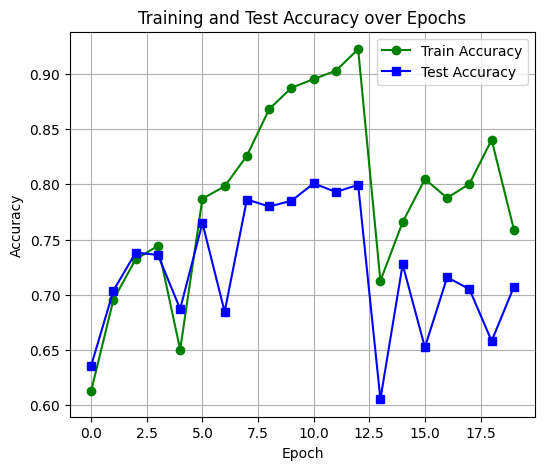

In [ ]:
plt.figure(figsize=(6, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o', color='green')
plt.plot(test_accuracies, label='Test Accuracy', marker='s', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
acc = accuracy_score(y_true_all, y_pred_all)
prec = precision_score(y_true_all, y_pred_all)
rec = recall_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all)
auc = roc_auc_score(y_true_all, y_pred_prob)

print("\n📌 Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


📌 Evaluation Metrics:
Accuracy : 0.7071
Precision: 0.7499
Recall   : 0.6216
F1 Score : 0.6797
AUC      : 0.7839


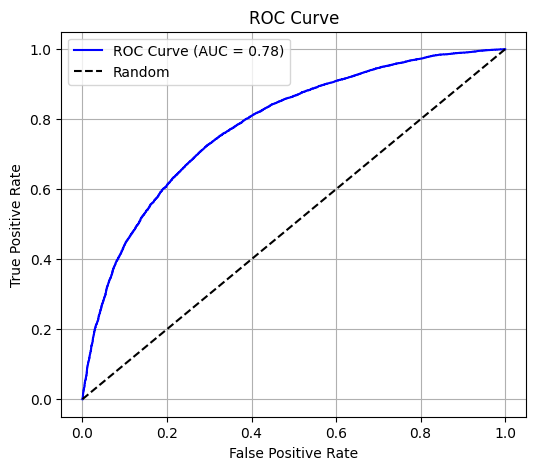

In [ ]:
fpr, tpr, _ = roc_curve(y_true_all, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

## LSTM Model

LSTM menggunakan 3 gerbang: input, forget, dan output gate untuk mengatasi masalah long-term dependency.

### Rumus LSTM:

**Forget gate:**
$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

**Input gate:**
$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

**Cell state:**
$$
C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
$$

**Output gate:**
$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
h_t = o_t \cdot \tanh(C_t)
$$

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm1 = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.lstm4 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.lstm5 = nn.LSTM(hidden_dim, hidden_dim//2, batch_first=True)

        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(hidden_dim//2, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x = x[:, -1, :]  # ambil output timestep terakhir
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [ ]:
lstm_model = LSTMModel(vocab_size=num_words).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

In [ ]:
train_losses_lstm, test_losses_lstm = [], []
train_accuracies_lstm, test_accuracies_lstm = [], []

epochs = 5
for epoch in range(epochs):
    lstm_model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = (outputs > 0.5).int()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses_lstm.append(running_loss / len(train_loader))
    train_accuracies_lstm.append(correct / total)

    # Validation
    lstm_model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

            preds = (outputs > 0.5).int()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    test_losses_lstm.append(val_loss / len(test_loader))
    test_accuracies_lstm.append(correct_val / total_val)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses_lstm[-1]:.4f} | Val Loss: {test_losses_lstm[-1]:.4f} | "
          f"Train Acc: {train_accuracies_lstm[-1]:.4f} | Val Acc: {test_accuracies_lstm[-1]:.4f}")

Epoch 1 | Train Loss: 0.6366 | Val Loss: 0.6481 | Train Acc: 0.6378 | Val Acc: 0.5972
Epoch 2 | Train Loss: 0.5266 | Val Loss: 0.5388 | Train Acc: 0.7528 | Val Acc: 0.7705
Epoch 3 | Train Loss: 0.4563 | Val Loss: 0.4527 | Train Acc: 0.7968 | Val Acc: 0.7988
Epoch 4 | Train Loss: 0.3946 | Val Loss: 0.3891 | Train Acc: 0.8313 | Val Acc: 0.8389
Epoch 5 | Train Loss: 0.2887 | Val Loss: 0.3563 | Train Acc: 0.8847 | Val Acc: 0.8486


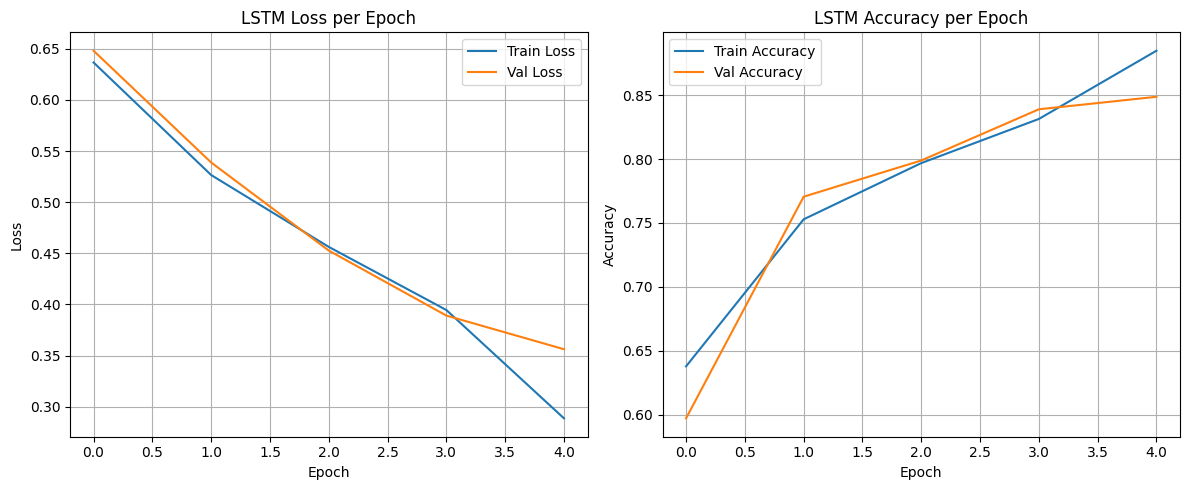

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_lstm, label='Train Loss')
plt.plot(test_losses_lstm, label='Val Loss')
plt.title('LSTM Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_lstm, label='Train Accuracy')
plt.plot(test_accuracies_lstm, label='Val Accuracy')
plt.title('LSTM Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


📊 LSTM Evaluation Metrics:
Accuracy : 0.8486
Precision: 0.8041
Recall   : 0.9219
F1 Score : 0.8590
AUC      : 0.9343


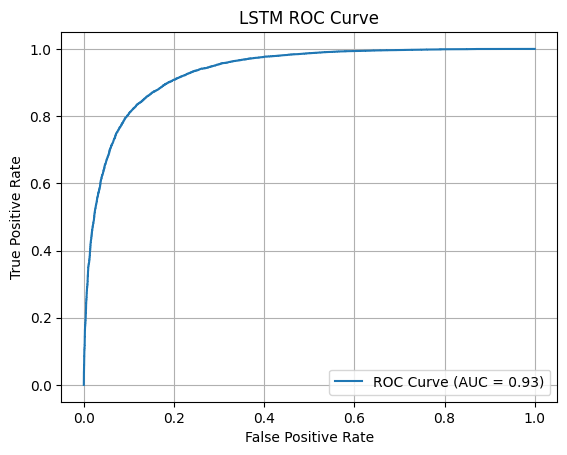

In [ ]:
lstm_model.eval()
y_pred_prob, y_pred_all, y_true_all = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = lstm_model(inputs).squeeze()
        y_pred_prob.extend(outputs.cpu().detach().tolist())
        y_pred_all.extend((outputs > 0.5).int().cpu().tolist())
        y_true_all.extend(labels.cpu().tolist())

acc = accuracy_score(y_true_all, y_pred_all)
prec = precision_score(y_true_all, y_pred_all)
rec = recall_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all)
auc = roc_auc_score(y_true_all, y_pred_prob)

print("\n📊 LSTM Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_all, y_pred_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.grid()
plt.legend()
plt.show()

## GRU Model

GRU (Gated Recurrent Unit)

GRU adalah penyederhanaan dari LSTM dengan 2 gate: reset dan update.

### Rumus GRU:

**Update gate:**
$$
z_t = \sigma(W_z \cdot [h_{t-1}, x_t])
$$

**Reset gate:**
$$
r_t = \sigma(W_r \cdot [h_{t-1}, x_t])
$$

**Candidate activation:**
$$
\tilde{h}_t = \tanh(W \cdot [r_t * h_{t-1}, x_t])
$$

**Final hidden state:**
$$
h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t
$$

In [ ]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, vocab_size=40000, embed_size=128, hidden_size=128, num_layers=3, dropout=0.3):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers,
                          batch_first=True, dropout=dropout, bidirectional=False)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        x = gru_out[:, -1, :]  # Ambil output dari timestep terakhir
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return self.sigmoid(x).squeeze()


In [ ]:
gru_model = GRUModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-3)

train_losses, test_losses = [], []
train_accs, test_accs = [], []
epochs = 5

for epoch in range(epochs):
    gru_model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = gru_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = (outputs > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # Evaluation
    gru_model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = gru_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (outputs > 0.5).int()
            correct += (preds == labels.int()).sum().item()
            total += labels.size(0)
    test_losses.append(val_loss / len(test_loader))
    test_accs.append(correct / total)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Test Acc: {test_accs[-1]:.4f}")

Epoch 1, Train Loss: 0.6118, Test Loss: 0.5109, Train Acc: 0.6578, Test Acc: 0.7520
Epoch 2, Train Loss: 0.3692, Test Loss: 0.3160, Train Acc: 0.8371, Test Acc: 0.8652
Epoch 3, Train Loss: 0.2441, Test Loss: 0.2919, Train Acc: 0.9026, Test Acc: 0.8800
Epoch 4, Train Loss: 0.1740, Test Loss: 0.3473, Train Acc: 0.9349, Test Acc: 0.8824
Epoch 5, Train Loss: 0.1196, Test Loss: 0.3760, Train Acc: 0.9582, Test Acc: 0.8788


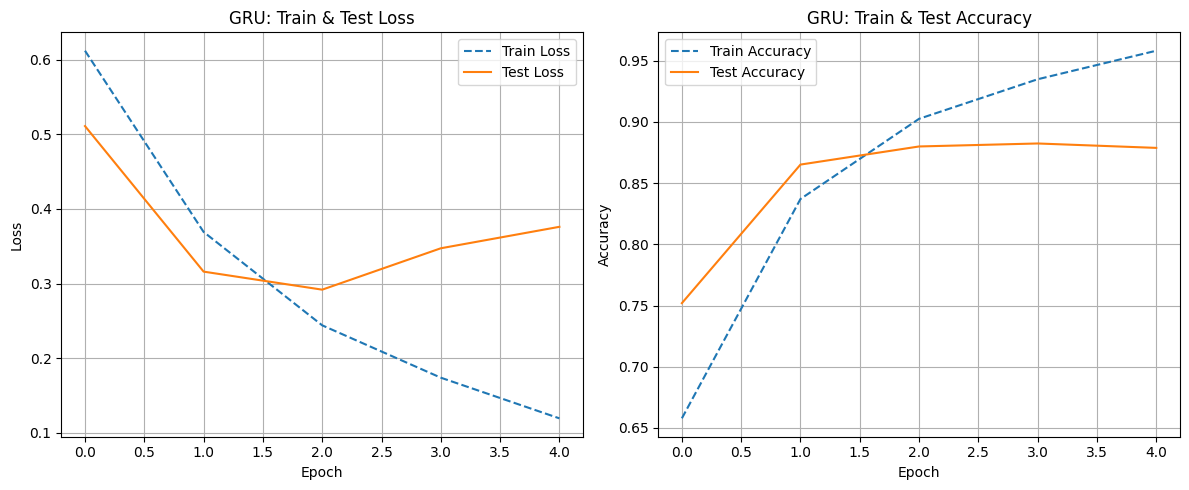

In [ ]:
plt.figure(figsize=(12,5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linestyle='--')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU: Train & Test Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', linestyle='--')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GRU: Train & Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

gru_model.eval()
y_pred_prob, y_pred_all, y_true_all = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = gru_model(inputs).squeeze()

        y_pred_prob.extend(outputs.cpu().tolist())
        y_pred_all.extend((outputs > 0.5).int().cpu().tolist())
        y_true_all.extend(labels.cpu().tolist())

acc = accuracy_score(y_true_all, y_pred_all)
prec = precision_score(y_true_all, y_pred_all)
rec = recall_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all)
auc = roc_auc_score(y_true_all, y_pred_prob)

print("\n📊 GRU Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")



📊 GRU Evaluation Metrics:
Accuracy : 0.8788
Precision: 0.9102
Recall   : 0.8406
F1 Score : 0.8740
AUC      : 0.9516


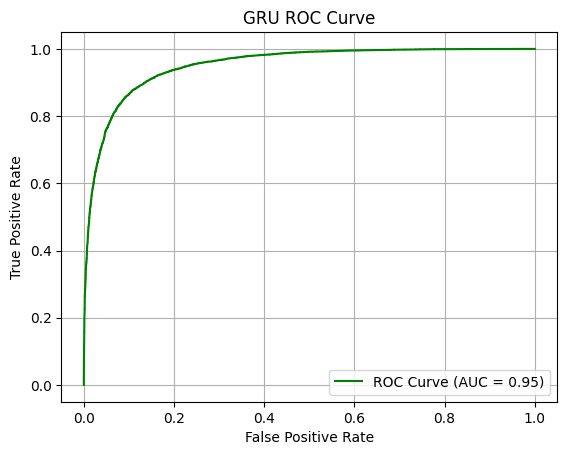

In [ ]:
fpr, tpr, _ = roc_curve(y_true_all, y_pred_prob)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='green')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GRU ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi Model: Persamaan Matematis dan Penjelasan

### 1. **Binary Cross Entropy Loss (BCELoss)**  
Digunakan sebagai *loss function* pada model klasifikasi biner untuk mengukur selisih antara probabilitas prediksi dan label sebenarnya.

$$
\mathcal{L}(y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]
$$

- Semakin kecil nilai loss, semakin baik model memprediksi label yang benar.
- Digunakan dalam proses *training* untuk memperbarui bobot model melalui backpropagation.

---

### 2. **Accuracy (Akurasi)**  
Mengukur proporsi prediksi yang benar dari seluruh data.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

- Cocok digunakan saat jumlah data positif dan negatif seimbang.
- Metrik paling umum untuk klasifikasi dasar.

---

### 3. **Precision**  
Mengukur seberapa banyak dari hasil prediksi positif yang benar-benar positif.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

- Tinggi ketika model jarang salah mengklasifikasikan negatif sebagai positif.
- Penting untuk kasus seperti deteksi spam.

---

### 4. **Recall (Sensitivity)**  
Mengukur seberapa banyak data positif yang berhasil terdeteksi dengan benar.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

- Tinggi ketika model tidak melewatkan banyak data positif.
- Penting untuk kasus seperti diagnosis penyakit.

---

### 5. **F1 Score**  
Merupakan harmonik rata-rata dari Precision dan Recall.

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

- Berguna saat terjadi ketidakseimbangan data.
- Memberikan keseimbangan antara Precision dan Recall.

---

### 6. **AUC dan ROC**  
Mengukur kemampuan model dalam membedakan antara kelas positif dan negatif.

$$
\text{AUC} = \int_0^1 TPR(FPR) \, dFPR
$$

Dengan:

$$
TPR = \frac{TP}{TP + FN} \quad , \quad FPR = \frac{FP}{FP + TN}
$$

- ROC Curve menampilkan hubungan antara TPR dan FPR.
- AUC = 1 menunjukkan performa sempurna, AUC = 0.5 berarti tebak-tebakan.
